##### imports 

In [201]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.optimize import differential_evolution   
import matplotlib.pylab as plt
from matplotlib.pyplot import savefig
from matplotlib.lines import Line2D
from scipy.integrate import solve_ivp
import pandas as pd
import math 
from datetime import date
from scipy.integrate import solve_ivp
import sys
import os
import copy 

In [207]:
df

,days,sum_tumor_lengths,Sum_tumor_volume,ID
4,0,58.7,13865.441833,A1002
5,62,30.3,1669.099500,A1002
6,110,24.1,1306.983167,A1002
7,152,26.0,1406.253333,A1002
8,187,26.0,1406.253333,A1002
...,...,...,...,...
150,533,26.0,2929.333333,E1012
151,575,26.0,2929.333333,E1012
152,631,26.0,2929.333333,E1012
153,687,26.0,2929.333333,E1012


##### data

In [235]:
# Reading data
df = pd.read_csv("Tumor_lengths.csv")
df = df.loc[~df['ID'].isin(['A1001','A1003', 'A1015', 'E1034'])] # remove patients with too few data points
df_anyue = pd.read_excel("Individual parameters_START_TKI patients_AYin.xlsx")
df_anyue = df_anyue[["PID","PD_Kg(/day)","PD_Kd(/day)","PD_Km(/day)"]]
df_anyue = df_anyue.rename(columns={"PID": "ID", "PD_Kg(/day)": "kg", "PD_Kd(/day)": "kd", "PD_Km(/day)": "km"})
df_anyue = df_anyue.loc[~df_anyue['ID'].isin(['A1001','A1003', 'A1015', 'E1034'])] # remove patients with too few data points
cols = df_anyue.columns.tolist()
cols[2],cols[3]=cols[3],cols[2] # swap kd and km so anyue's columns match ours
df_anyue = df_anyue[cols]

In [236]:
df.loc[df["ID"] == "A1009"]


,days,sum_tumor_lengths,Sum_tumor_volume,ID
63,0,91.0,18055.166670,A1009
64,67,50.0,5253.333333,A1009
65,109,42.0,3773.000000,A1009
66,151,42.0,3773.000000,A1009
67,193,49.0,7260.166667,A1009
68,230,59.0,7427.333000,A1009


##### functions 

In [238]:
# Gompertizian population model
def system_ode_gompertizian(days,populations, params):
    Spop = populations[0]
    Rpop = populations[1]
    r = params[0] #growth rate
    kmax = params[1] #carrying capacity
    lam = params[2] #sensitivity to medication
    m=1
    epsilon = 1e-9
    log_arg = kmax/(Spop + Rpop + epsilon) # stop division by 0

    if log_arg <= 0:
        return [1e30, 1e30] # return large error if log is 0 or negative

    dSpop_dt = r *np.log(kmax/(Spop+Rpop + epsilon)) * (1-lam*m)*Spop 
    dRpop_dt = r * np.log(kmax/(Spop+Rpop + epsilon))*Rpop
    return [dSpop_dt, dRpop_dt]

# Gompertizian cost function
def cost_func_gompertizian(params, days, data):
    initial_populations = params[3:]
    tspan = [days[0], days[-1]]
    epsilon = 1e-9
    
    pred_data = solve_ivp(system_ode_gompertizian, tspan, initial_populations, 
                             t_eval = np.ravel(days),  args = tuple([params[:3]]))
    
    if pred_data.y.shape[1] == np.ravel(days).shape[0]:
        spop = pred_data.y[0]
        rpop = pred_data.y[1]
        sum_pops = spop + rpop
        sumsq_error = np.sum((sum_pops-data)**2)
        msq_error = sumsq_error/len(data)
        rmse = np.sqrt(msq_error)
    else: 
        msq_error = 1e30
        rmse = 1e30

    return msq_error


##### fitting model

In [240]:
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    print("Working on patient:", id, " Number of data points:", len(days))

# fitting patient data to equations (r,Kmax,lamda,spop,rpop)
    max_value = max(data[0], data[-1])

    # these are pretty good - don't delete 
    bounds = [(1e-3, 2e-1), (1.1*max_value, 2*max_value), (1e-1, 10),(0, data[0]), (0, 3*data[0])]
    init_params = [1e-2, 1.2*max_value,3, data[0]-1e-3, 1e-3]

    #trying these
    bounds = [(1e-3, 2e-1), (1.1*max_value, 2*max_value), (1e-1, 10),(0, data[0]), (0, 3*data[0])]
    init_params = [1e-2, 1.2*max_value,3, data[0]-1e-3, 1e-3]

    opt_result_log = minimize(cost_func_gompertizian, init_params, 
                              args=(days, data), bounds = bounds, method="nelder-mead")
    # store the optimal parameters and the cost function value (last entry in list)
    master_dictionary[id] = opt_result_log.x.tolist() + [opt_result_log.fun] 


Working on patient: A1002  Number of data points: 16
Working on patient: A1004  Number of data points: 5
Working on patient: A1006  Number of data points: 9
Working on patient: A1007  Number of data points: 13
Working on patient: A1008  Number of data points: 12
Working on patient: A1009  Number of data points: 6
Working on patient: A1011  Number of data points: 5
Working on patient: A1012  Number of data points: 10
Working on patient: A1013  Number of data points: 7
Working on patient: A1014  Number of data points: 18
Working on patient: A1016  Number of data points: 14
Working on patient: A1017  Number of data points: 7
Working on patient: E1008  Number of data points: 6
Working on patient: E1012  Number of data points: 16


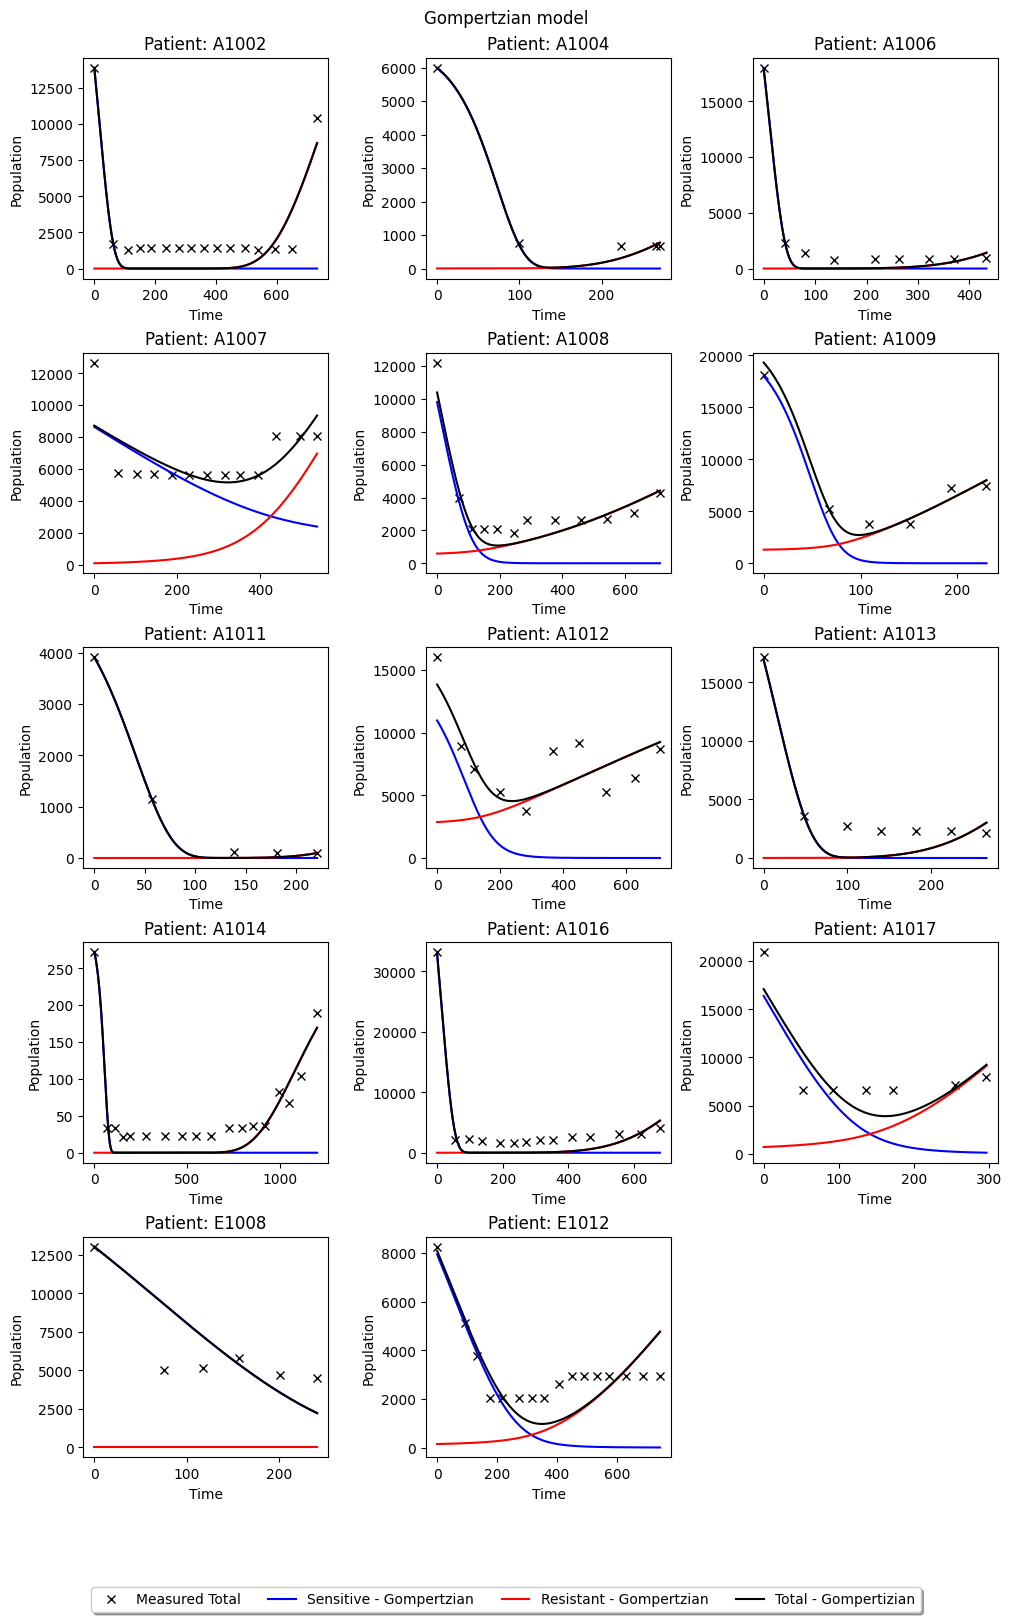

In [242]:
# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_gom = master_dictionary[id]
    init_populations_gom = optimal_params_gom[3:-1]

    pred_data_gom = solve_ivp(system_ode_gompertizian, [0,days[-1]],
                            init_populations_gom, dense_output=True,
                            args = tuple([optimal_params_gom[:3]]))
    sum_pops_gom = np.sum(pred_data_gom.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_gom.sol(tspan)[0], 'b-', label='Sensitive - Gompertz ')
    ax.plot(tspan, pred_data_gom.sol(tspan)[1], 'r-', label='Resistant - Gompertz') 
    ax.plot(tspan, sum_pops_gom, 'k-', label='Total - Gompertz')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Gompertzian'),
                   Line2D([0], [0], color='r', label='Resistant - Gompertzian'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Gompertizian'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Gompertzian model')  
plt.show()

In [243]:
df_gomp = pd.DataFrame.from_dict(master_dictionary, orient='index', 
                                     columns=['r','Kmax','lamda','spop_0','rpop_0','mse'])
df_gomp

,r,Kmax,lamda,spop_0,rpop_0,mse
A1002,0.006097,27458.971922,4.684258,13865.441810,5.523499e-15,1.837706e+06
A1004,0.007457,6686.003777,5.068706,5988.031594,3.884241e+00,2.935612e+04
A1006,0.003677,35983.756433,9.999690,17940.110879,9.680524e-02,5.040203e+05
A1007,0.006068,25338.275340,1.288555,8633.050563,8.013682e+01,2.178808e+06
A1008,0.001227,24420.333340,10.000000,9801.245150,5.879503e+02,6.928867e+05
A1009,0.005937,22463.583459,7.638462,17982.230358,1.305262e+03,6.866118e+05
A1011,0.009551,5352.614223,3.921829,3912.000000,8.415630e-03,3.841248e+03
A1012,0.001754,17594.133337,10.000000,10957.411034,2.864296e+03,3.282041e+06
A1013,0.006485,32993.342382,4.832247,16925.030254,4.706290e+00,2.421525e+06
A1014,0.004652,299.016667,9.999788,271.833333,1.211367e-23,5.261301e+02


##### Gompertzian with DE for parameters

In [244]:
from scipy.optimize import differential_evolution
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 

## Find optimal parameters for each patient
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    max_value = max(data[0], data[-1])

    print("Working on patient:", id, " Number of data points:", len(days))
    #bounds = [(1e-3, 2e-1), (1.1*max_value, 2*max_value), (1e-1, 10),(0, data[0]), (0, 3*data[0])] # these were ok
    bounds = [(1e-4, 2e-1), (1.1*max_value, 2*max_value), (1e-1, 1000),(0, data[0]), (0, 3*data[0])]

    # Use differential_evolution to perform a random search
    opt_result_log = differential_evolution(cost_func_gompertizian, bounds, args=(days, data))
    # store the optimal parameters and the cost function value (last entry in list)
    master_dictionary[id] = opt_result_log.x.tolist() + [opt_result_log.fun]

Working on patient: A1002  Number of data points: 16


C:\Users\lstocker\AppData\Local\Temp\ipykernel_31460\3376385897.py:32: RuntimeWarning: overflow encountered in square
  sumsq_error = np.sum((sum_pops-data)**2)


Working on patient: A1004  Number of data points: 5
Working on patient: A1006  Number of data points: 9
Working on patient: A1007  Number of data points: 13
Working on patient: A1008  Number of data points: 12
Working on patient: A1009  Number of data points: 6
Working on patient: A1011  Number of data points: 5
Working on patient: A1012  Number of data points: 10
Working on patient: A1013  Number of data points: 7
Working on patient: A1014  Number of data points: 18
Working on patient: A1016  Number of data points: 14
Working on patient: A1017  Number of data points: 7
Working on patient: E1008  Number of data points: 6
Working on patient: E1012  Number of data points: 16


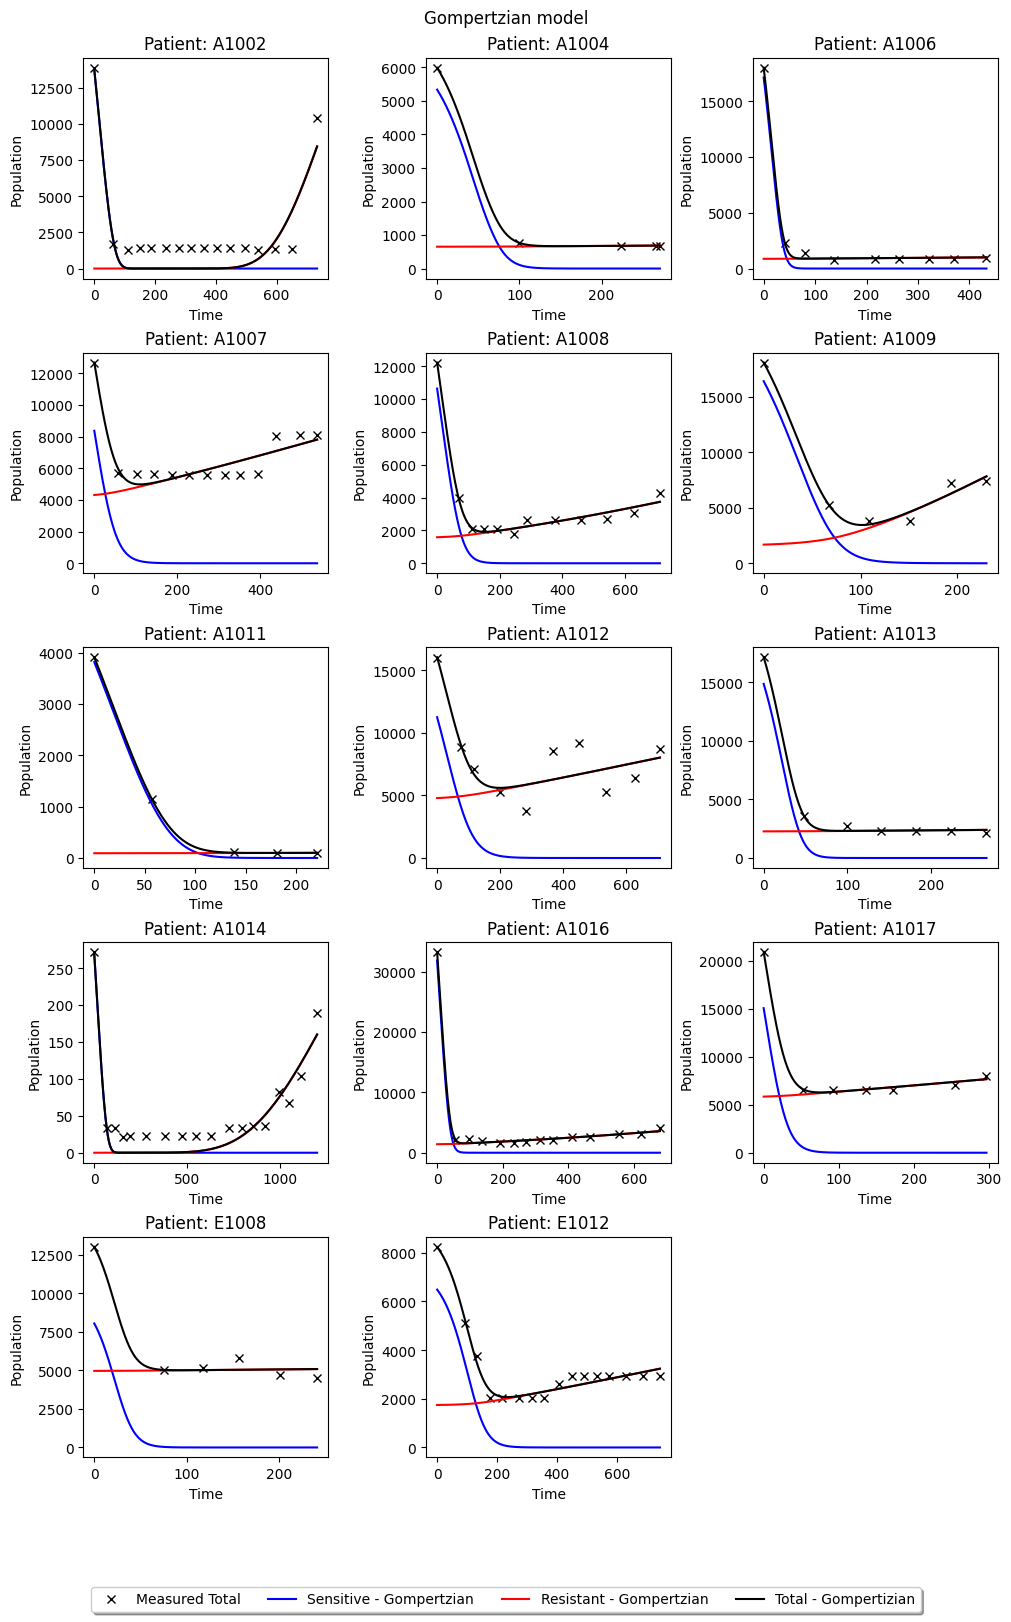

In [245]:
  
# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_gom = master_dictionary[id]
    init_populations_gom = optimal_params_gom[3:-1]

    pred_data_gom = solve_ivp(system_ode_gompertizian, [0,days[-1]],
                            init_populations_gom, dense_output=True,
                            args = tuple([optimal_params_gom[:3]]))
    sum_pops_gom = np.sum(pred_data_gom.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_gom.sol(tspan)[0], 'b-', label='Sensitive - Gompertz ')
    ax.plot(tspan, pred_data_gom.sol(tspan)[1], 'r-', label='Resistant - Gompertz') 
    ax.plot(tspan, sum_pops_gom, 'k-', label='Total - Gompertz')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Gompertzian'),
                   Line2D([0], [0], color='r', label='Resistant - Gompertzian'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Gompertizian'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Gompertzian model')  
plt.show()

In [246]:
df_gomp = pd.DataFrame.from_dict(master_dictionary, orient='index', 
                                     columns=['r','Kmax','lamda','spop_0','rpop_0','mse'])
df_gomp

,r,Kmax,lamda,spop_0,rpop_0,mse
A1002,0.005905,27627.571126,4.616822,13730.116272,1.128280e-13,1.867360e+06
A1004,0.000100,7337.041740,361.087480,5338.438083,6.510866e+02,6.993511e+00
A1006,0.000100,28820.040866,473.077009,17125.645002,8.706399e+02,3.618309e+04
A1007,0.000801,25263.697822,36.225680,8359.631326,4.306580e+03,3.609513e+05
A1008,0.000579,23497.209693,34.157550,10633.576418,1.583536e+03,7.277239e+04
A1009,0.004719,25394.951048,7.197947,16399.769235,1.679125e+03,3.309537e+05
A1011,0.000115,7822.187455,162.573633,3818.951234,9.267836e+01,5.012971e+01
A1012,0.000592,24331.138832,33.993112,11252.891706,4.786393e+03,2.150470e+06
A1013,0.000100,23037.451170,535.362412,14876.256493,2.275136e+03,4.094543e+04
A1014,0.002362,543.664474,9.724622,268.276891,5.147691e-05,3.854495e+02


##### Gompertzian DE with 1/2 dose 

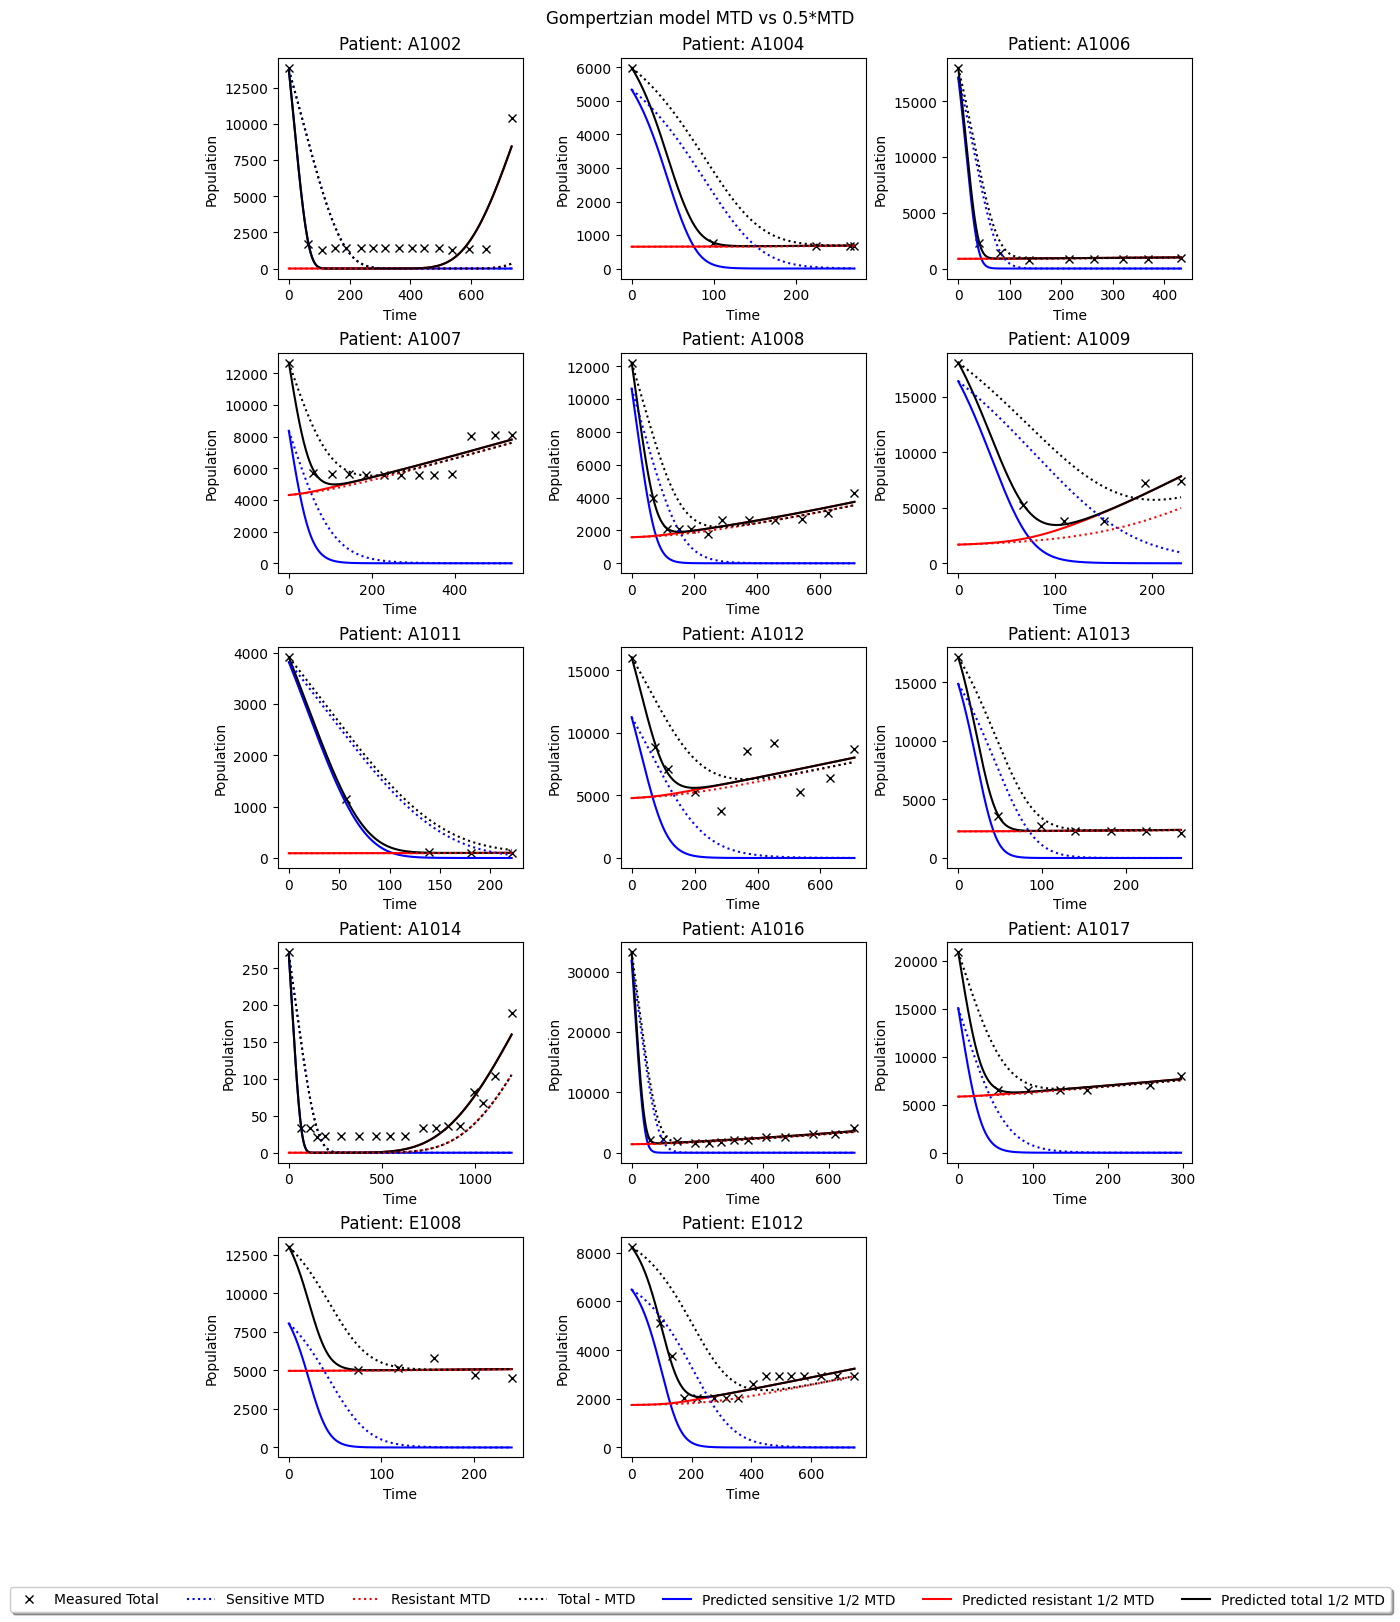

In [247]:
master_dictionary_copy = copy.deepcopy(master_dictionary) # deep to create a copy that can be changed
for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5

# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data for parameters with half medication
for index, id in enumerate(unique_IDs, start=0):
    
    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    ### optimal params original medication 
    optimal_params = master_dictionary[id]
    init_populations = optimal_params[3:-1]

    pred_data = solve_ivp(system_ode_gompertizian, [0,days[-1]],
                            init_populations, dense_output=True,
                            args = tuple([optimal_params[:3]]))
    sum_pops = np.sum(pred_data.sol(tspan), axis=0)

    ### optimal params 1/2 medication
    optimal_params_half = master_dictionary_copy[id] # use parameters with 1/2 medication
    init_populations_half = optimal_params_half[3:-1]

    pred_data_half = solve_ivp(system_ode_gompertizian, [0,days[-1]],
                            init_populations_half, dense_output=True, max_step = 1e-2,
                            args = tuple([optimal_params_half[:3]]))
    sum_pops_half = np.sum(pred_data_half.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    #plot data
    ax.plot(days, data, 'kx', label='Measured Total') 
    # plot with full medication
    ax.plot(tspan, pred_data.sol(tspan)[0], 'b-', label='Sensitive MTD') # plot logistic model
    ax.plot(tspan, pred_data.sol(tspan)[1], 'r-', label='Resistant MTD') 
    ax.plot(tspan, sum_pops, 'k-', label='Total MTD')

    # plot with half medication
    ax.plot(tspan, pred_data_half.sol(tspan)[0], 'b:', label='Sensitive 0.5*MTD') 
    ax.plot(tspan, pred_data_half.sol(tspan)[1], 'r:', label='Resistant 0.5*MTD') 
    ax.plot(tspan, sum_pops_half, 'k:', label='Total 0.5*MTD')

    #set axis labels
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', linestyle=':',label='Sensitive MTD'),
                   Line2D([0], [0], color='r',linestyle=':', label='Resistant MTD'),
                   Line2D([0], [0], color='k', linestyle=':',label='Total - MTD'),

                   Line2D([0], [0], color='b',  label='Predicted sensitive 1/2 MTD'),
                   Line2D([0], [0], color='r',  label='Predicted resistant 1/2 MTD'),
                   Line2D([0], [0], color='k', label='Predicted total 1/2 MTD')]


fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Gompertzian model MTD vs 0.5*MTD')  
plt.show()

##### Extended predictions 1/2 MTD vs MTD

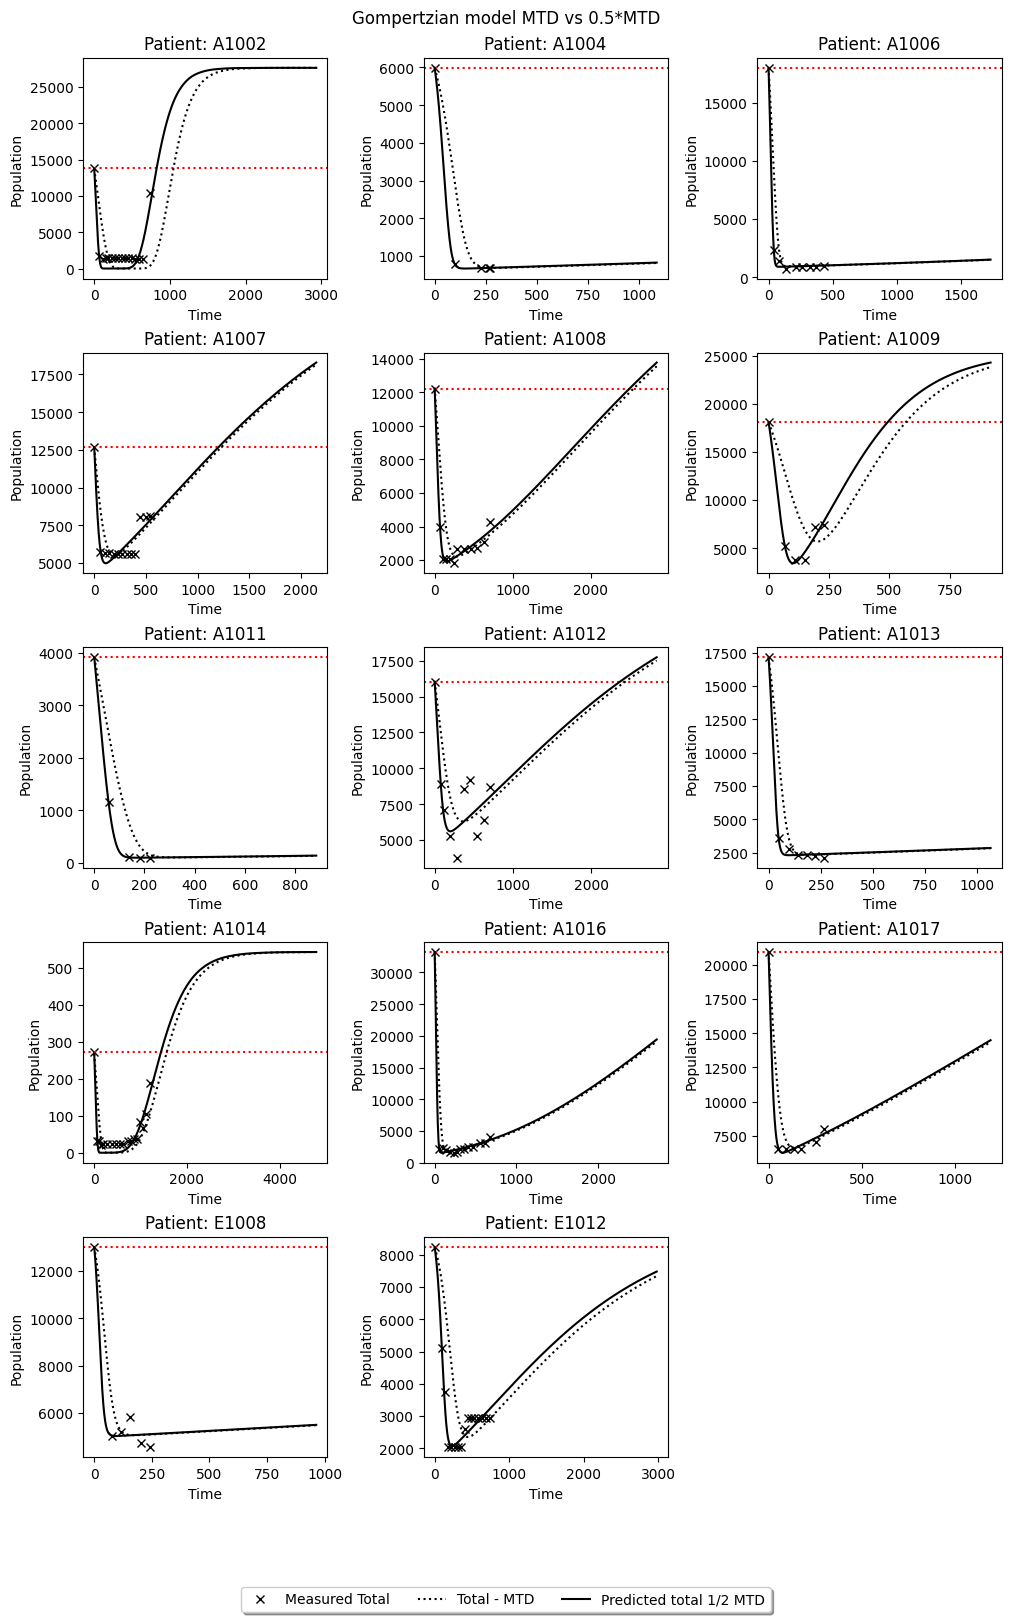

In [252]:
master_dictionary_copy = copy.deepcopy(master_dictionary) # deep to create a copy that can be changed
for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5

# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data for parameters with half medication
for index, id in enumerate(unique_IDs, start=0):
    
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()

    sim_time_factor = 4

    tspan = np.linspace(0, sim_time_factor*days[-1], 1000)

    ### optimal params original medication 
    optimal_params = master_dictionary[id]
    init_populations = optimal_params[3:-1]

    pred_data = solve_ivp(system_ode_gompertizian, [0,sim_time_factor*days[-1]],
                            init_populations, dense_output=True,
                            args = tuple([optimal_params[:3]]))
    sum_pops = np.sum(pred_data.sol(tspan), axis=0)

    ### optimal params 1/2 medication
    optimal_params_half = master_dictionary_copy[id] # use parameters with 1/2 medication
    init_populations_half = optimal_params_half[3:-1]

    pred_data_half = solve_ivp(system_ode_gompertizian, [0,sim_time_factor*days[-1]],
                            init_populations_half, dense_output=True, 
                            args = tuple([optimal_params_half[:3]]))
    sum_pops_half = np.sum(pred_data_half.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    ax.plot(days, data, 'kx', label='Measured Total') 
    ax.axhline(y=data[0], color='r', linestyle=':')

    # plot with full medication
    #ax.plot(tspan, pred_data.sol(tspan)[0], 'b-', label='Sensitive MTD') # plot logistic model
    #ax.plot(tspan, pred_data.sol(tspan)[1], 'r-', label='Resistant MTD') 
    ax.plot(tspan, sum_pops, 'k-', label='Total MTD')

    # plot with half medication
   # ax.plot(tspan, pred_data_half.sol(tspan)[0], 'b:', label='Sensitive 0.5*MTD') 
    #ax.plot(tspan, pred_data_half.sol(tspan)[1], 'r:', label='Resistant 0.5*MTD') 
    ax.plot(tspan, sum_pops_half, 'k:', label='Total 0.5*MTD')

    #set axis labels
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   #Line2D([0], [0], color='b', linestyle=':',label='Sensitive MTD'),
                  # Line2D([0], [0], color='r',linestyle=':', label='Resistant MTD'),
                   Line2D([0], [0], color='k', linestyle=':',label='Total - MTD'),

                  # Line2D([0], [0], color='b',  label='Predicted sensitive 1/2 MTD'),
                  # Line2D([0], [0], color='r',  label='Predicted resistant 1/2 MTD'),
                   Line2D([0], [0], color='k', label='Predicted total 1/2 MTD')]


fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Gompertzian model MTD vs 0.5*MTD')  
plt.show()

##### gompertz with wider bounds